In [95]:
# Auto-reload setup
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
print(sys.executable)

sys.path.append(os.path.abspath("../src"))
from plotting_price_drivers import *
from merit_order import *
# from jao_scrapping import *
# from jao_master_dataset import *
# from jao_downsampling import *
# from jao_dst_handling import *

/usr/local/bin/python3


In [97]:
master_path = '../data/clean/fbmc/master_dataset_15min_WITH_PRICE.csv'
flow_path_fake = '../data/clean/fbmc/line_flows_fbmc_fake_ptdf.csv'
flow_path_real = '../data/clean/fbmc/line_flows_fbmc_real_ptdf.csv'
spread_path = '../data/clean/fbmc/spread_dataset_FR.csv'

df_master = pd.read_csv(master_path, parse_dates=['Time'])
df_flow = pd.read_csv(flow_path_real, parse_dates=['Time'])
df_spread = pd.read_csv(spread_path, parse_dates=['Time'])

print(df_flow.head())

                 Time                              Line      Flow_MW  \
0 2025-01-01 00:00:00                     Gonyu - Gyor     25.802338   
1 2025-01-01 00:00:00           Hradec - Rohrsdorf 446   1561.816337   
2 2025-01-01 00:00:00  Maasbracht - Oberzier 380 white    513.064206   
3 2025-01-01 00:00:00                Nosovice - Varin    1329.138258   
4 2025-01-01 00:15:00                     Gonyu - Gyor     35.355167   

      hubFrom       hubTo  RAM  utilization  congested  
0          SK          SI  639     0.040379      False  
1          DE          CZ  849     1.839595       True  
2  BE_AL_HVDC  DE_AL_HVDC  536     0.957209      False  
3          CZ          SK  909     1.462198       True  
4          SK          SI  639     0.055329      False  


**JAO files handling**: Compute and concatenate ptdf and ram data for all 2025 and set the time resolution to 15min.
- **jao_scrapping.py** : Collect daily files with the wanted data
- **jao_master_dataset.py** : Concatenate all the files into one unique dataset and keep only the relevant columns
- **jao_downsampling.py** : Set the time resoltion to 15min by downsampling the existing 1h resolution
- **jao_dst_handling.py** : Clean the time column by removing DST days and timezone

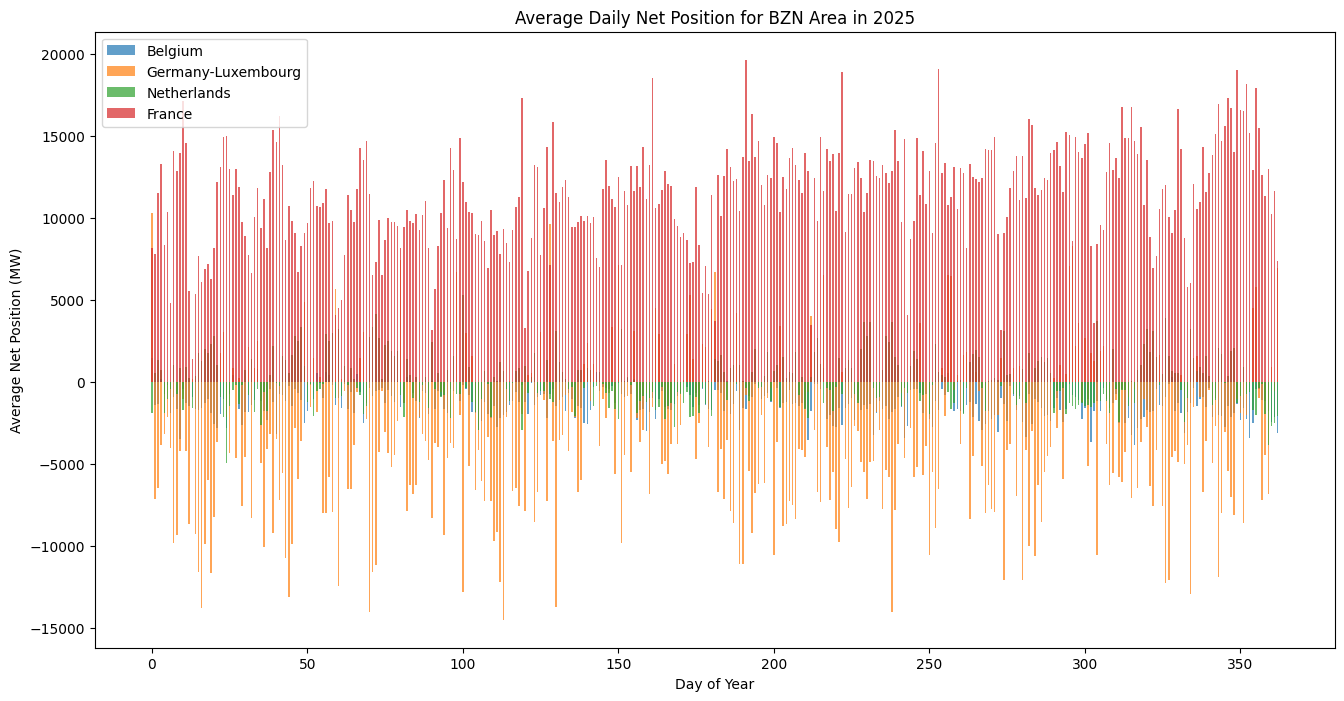

In [98]:
# Plot average net position for BZN area by day of year, separated by area
def plot_daily_NP_by_area(df, area):
    df = df.copy()
    df['day'] = df['Time'].dt.dayofyear

    if area in ['BE', 'DE', 'NL', 'FR']:
        df_area = df[df['Area'] == area]
        plt.figure(figsize=(16, 8))
        plt.bar(range(0,363),df_area.groupby('day')['Net position'].mean(), width=0.5, alpha=0.7)
        plt.xlabel('Day of Year')
        plt.ylabel('Average Net Position (MW)')
        plt.title(f'Average Daily Net Position for {area} in 2025')
        plt.legend([area])
        plt.show()
    else:
        plt.figure(figsize=(16, 8))
        plt.bar(range(0,363),df[df['Area'] == 'BE'].groupby('day')['Net position'].mean(), width=0.5, alpha=0.7)
        plt.bar(range(0,363),df[df['Area'] == 'DE'].groupby('day')['Net position'].mean(), width=0.5, alpha=0.7)
        plt.bar(range(0,363),df[df['Area'] == 'NL'].groupby('day')['Net position'].mean(), width=0.5, alpha=0.7)
        plt.bar(range(0,363),df[df['Area'] == 'FR'].groupby('day')['Net position'].mean(), width=0.5, alpha=0.7)
        plt.xlabel('Day of Year')
        plt.ylabel('Average Net Position (MW)')
        plt.title('Average Daily Net Position for BZN Area in 2025')
        plt.legend(['Belgium', 'Germany-Luxembourg', 'Netherlands', 'France'])
        plt.show()
    
plot_daily_NP_by_area(df_master, None)

In [99]:
def filter_country_congestion(df, country_code):
    """
    Filter the dataframe for a specific country by checking 
    the Origin and Destination of the flow lines
    """
    df = df.copy()
    if country_code == None:
        return df

    df_country = df[(df['hubFrom'].str.contains(country_code)) | (df['hubTo'].str.contains(country_code))]
    return df_country

/var/folders/7s/6pwwhvlj7rl3360yqcm6wmv40000gn/T/ipykernel_41629/3350803041.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country_top['hour'] = df_country_top['Time'].dt.hour


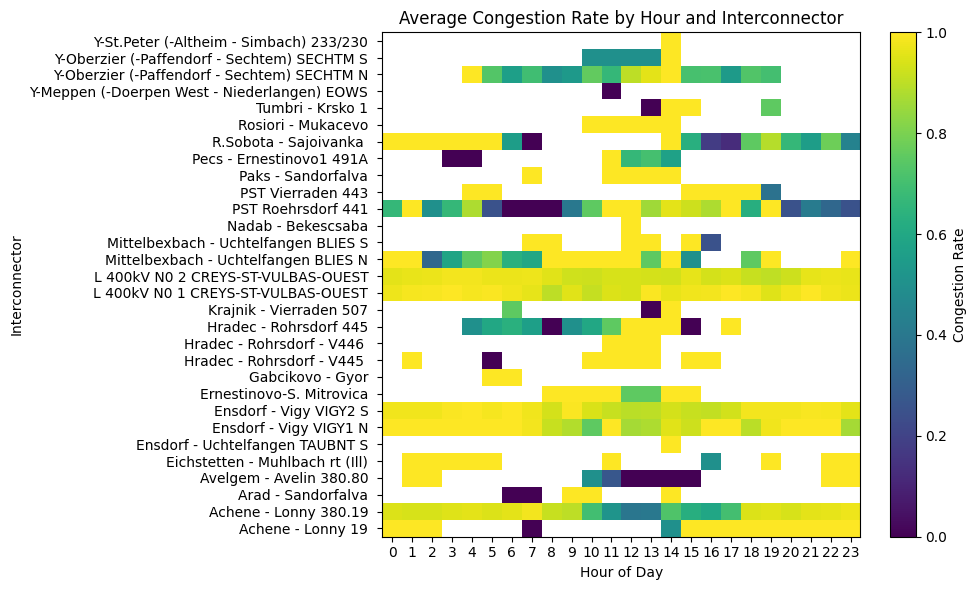

In [100]:
def plot_congestion_by_hour(df, n, country_code):
    """
    Plot congestion rate by hour of day for top n interconnectors for a specific country
    """
    df_country = filter_country_congestion(df, country_code)

    # Identify top n interconnectors by average flow
    top_groups = (
        df_country.groupby(['Line'])['Flow_MW']
        .mean()
        .nlargest(n)
        .index
    )

    df_country_top = df_country[df_country['Line'].isin(top_groups)]
    df_country_top['hour'] = df_country_top['Time'].dt.hour

    # --- Heat Map Plot ---
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot_table = df_country_top.pivot_table(index="Line", columns="hour", values="congested", aggfunc="mean")
    
    cax = ax.imshow(pivot_table, aspect='auto', cmap='viridis', origin='lower')
    ax.set_title("Average Congestion Rate by Hour and Interconnector")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Interconnector")
    ax.set_xticks(range(0, 24))
    ax.set_yticks(range(len(pivot_table.index)))
    ax.set_yticklabels(pivot_table.index)
    fig.colorbar(cax, ax=ax, label="Congestion Rate")
    plt.tight_layout()
    plt.show()

plot_congestion_by_hour(df_flow, 30, None)

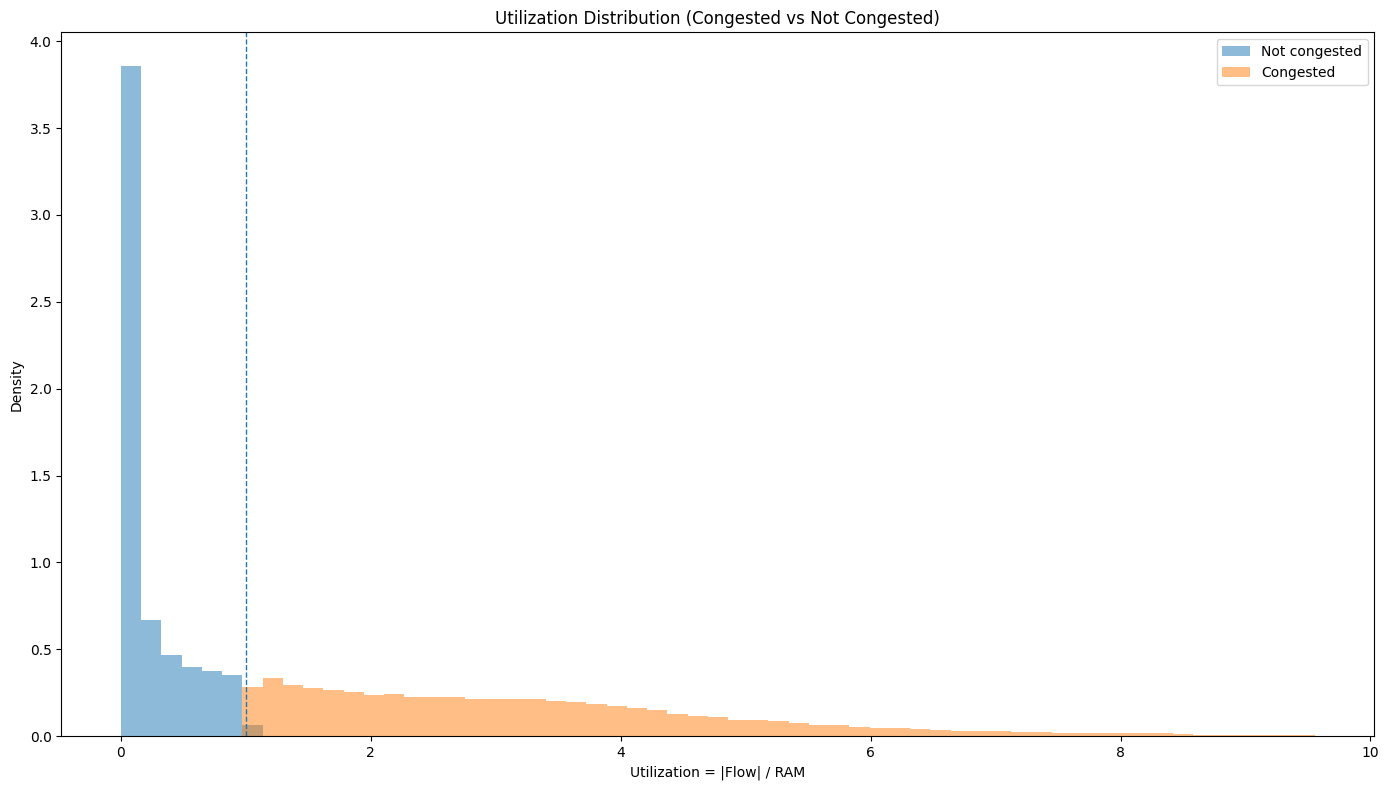

In [101]:
# Plot utilization distributions for congested vs not congested flows
def plot_distribution_by_congestion(df, n_bins=60):
    df = df.copy()
    df["congested"] = df["congested"].astype(bool)
    df["utilization"] = pd.to_numeric(df["utilization"], errors="coerce")
    df = df.dropna(subset=["utilization", "congested"])

    # Utilization distributions, split by congested flag
    util_cong = df.loc[df["congested"], "utilization"].to_numpy()
    util_free = df.loc[~df["congested"], "utilization"].to_numpy()

    # Choose bins robustly (ignore extreme outliers for bin range)
    hi = np.nanpercentile(df["utilization"], 99.5)
    hi = max(hi, 1.5)  # keep some headroom even if data is tight
    bins = np.linspace(0, hi, n_bins)

    fig, ax = plt.subplots(figsize=(14, 8))

    ax.hist(util_free, bins=bins, density=True, alpha=0.5, label="Not congested")
    ax.hist(util_cong, bins=bins, density=True, alpha=0.5, label="Congested")

    ax.axvline(1.0, linestyle="--", linewidth=1)  # utilization = 1 threshold
    ax.set_title("Utilization Distribution (Congested vs Not Congested)")
    ax.set_xlabel("Utilization = |Flow| / RAM")
    ax.set_ylabel("Density")
    ax.legend()

    plt.tight_layout()
    plt.show()

plot_distribution_by_congestion(df_flow, 60)

   Unnamed: 0                Time                     Line   RAM  utilization  \
0         264 2025-01-01 11:00:00   Achene - Lonny 380.19   1531     0.763687   
1         273 2025-01-01 11:15:00   Achene - Lonny 380.19   1531     0.807965   
2         282 2025-01-01 11:30:00   Achene - Lonny 380.19   1531     0.854768   
3         291 2025-01-01 11:45:00   Achene - Lonny 380.19   1531     0.879877   
4        1544 2025-01-04 15:00:00  Ensdorf - Vigy VIGY2 S    722     4.063076   

   congested  Spread FR-BE  Spread FR-DE  Spread FR-NL From  To  \
0      False           0.0         20.69        -16.90   FR  BE   
1      False           0.0         20.69        -16.90   FR  BE   
2      False           0.0         20.69        -16.90   FR  BE   
3      False           0.0         20.69        -16.90   FR  BE   
4       True           0.0        -26.77          2.93   FR  DE   

   Flow_normalized  export_constrained  import_constrained  
0      1169.205036               False           

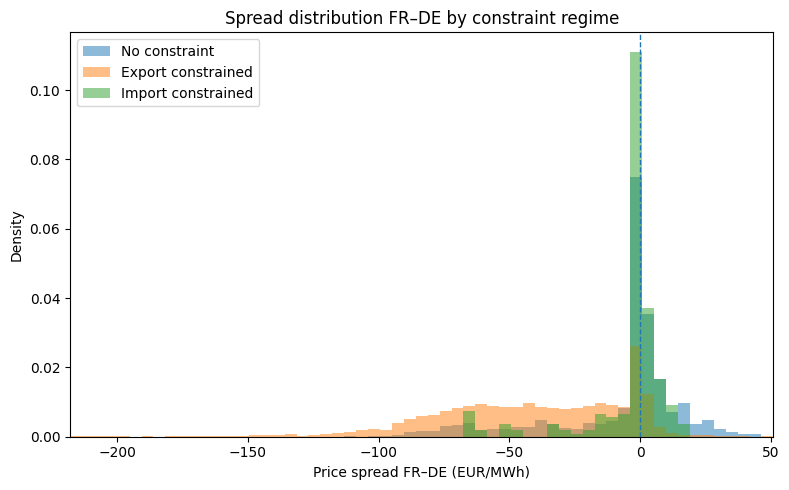

          regime  n_obs  mean_spread  mean_abs_spread  median_abs_spread  \
0  no_constraint   1245    -4.577791        15.508924               4.73   
1    export_only  12637   -38.281110        39.470690              35.02   
2    import_only    238    -1.319832         7.661345               0.82   

   share_of_time  
0       0.088173  
1       0.894972  
2       0.016856  


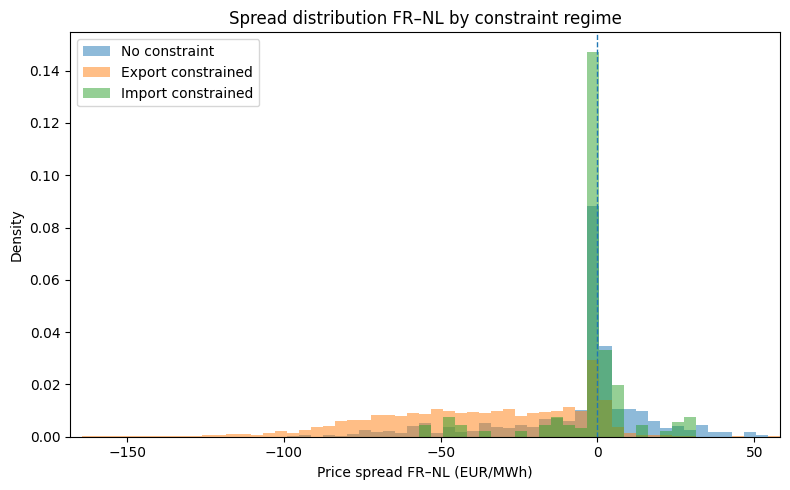

          regime  n_obs  mean_spread  mean_abs_spread  median_abs_spread  \
0  no_constraint   1245    -5.426594        11.159414               1.61   
1    export_only  12637   -30.465463        31.041044              25.41   
2    import_only    238    -1.475084         6.024580               0.16   

   share_of_time  
0       0.088173  
1       0.894972  
2       0.016856  


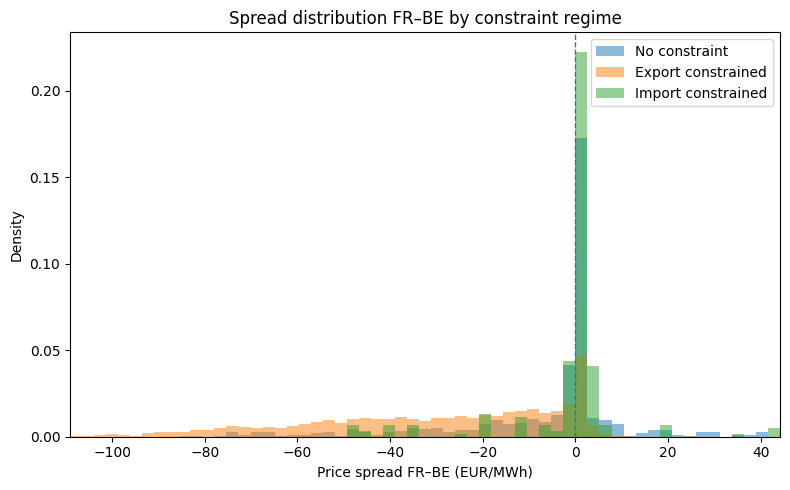

In [121]:
print(df_spread.head())

def plot_spread_by_fr_constraint(
    df: pd.DataFrame,
    country: str,
    lower_q: float = 0.5,
    upper_q: float = 99.8,
    n_bins: int = 60,
):
    """
    Plot distribution of FR-country price spread split by:
    - no constraint
    - export constrained
    - import constrained

    Histogram bin range is defined using quantiles to ignore extreme outliers.
    """

    spread_col = f"Spread FR-{country}"
    if spread_col not in df.columns:
        raise ValueError(f"Column '{spread_col}' not found in dataframe")

    x = df.copy()

    # --- France-level constraint state ---
    fr_state = (
        x.groupby("Time")[["export_constrained", "import_constrained"]]
         .any()
         .reset_index()
    )

    # --- One spread value per timestep ---
    spreads = (
        x[["Time", spread_col]]
        .drop_duplicates(subset=["Time"])
    )

    data = spreads.merge(fr_state, on="Time", how="left")

    # --- Define regimes ---
    no_constraint = data.loc[
        ~data["export_constrained"] & ~data["import_constrained"],
        spread_col
    ]

    export_constraint = data.loc[
        data["export_constrained"],
        spread_col
    ]

    import_constraint = data.loc[
        data["import_constrained"],
        spread_col
    ]

    # --- Robust bin range (ignore extreme outliers) ---
    all_spreads = data[spread_col].dropna()

    lo = np.percentile(all_spreads, lower_q)
    hi = np.percentile(all_spreads, upper_q)

    # Ensure zero is visible
    lo = min(lo, 0.0)
    hi = max(hi, 0.0)

    bins = np.linspace(lo, hi, n_bins)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.hist(no_constraint, bins=bins, density=True, alpha=0.5, label="No constraint")
    ax.hist(export_constraint, bins=bins, density=True, alpha=0.5, label="Export constrained")
    ax.hist(import_constraint, bins=bins, density=True, alpha=0.5, label="Import constrained")

    ax.axvline(0, linestyle="--", linewidth=1)
    ax.set_xlim(lo, hi)

    ax.set_title(f"Spread distribution FR–{country} by constraint regime")
    ax.set_xlabel(f"Price spread FR–{country} (EUR/MWh)")
    ax.set_ylabel("Density")
    ax.legend()

    plt.tight_layout()
    plt.show()



def spread_regime_diagnostics(
    df: pd.DataFrame,
    country: str,
    lower_q: float = None,
    upper_q: float = None,
) -> pd.DataFrame:
    """
    Compute diagnostics for FR-country spread by France-level constraint regime:
    - share of time in each regime
    - mean |spread| per regime

    Parameters
    ----------
    df : pd.DataFrame
        France-filtered line-level dataset.
        Must contain:
        - Time
        - export_constrained (line-level)
        - import_constrained (line-level)
        - Spread FR-{country}

    country : str
        Neighbor country code (e.g. "DE", "BE", "NL")

    lower_q, upper_q : float or None
        Optional quantile trimming for spread stats (e.g. 1 and 99).
        If provided, mean |spread| is computed on spreads clipped to [q_low, q_high]
        to reduce influence of extreme outliers. Regime shares are NOT affected.

    Returns
    -------
    pd.DataFrame
        Table with regime counts, share, mean spread, mean abs spread.
    """

    spread_col = f"Spread FR-{country}"
    if spread_col not in df.columns:
        raise ValueError(f"Column '{spread_col}' not found in dataframe")

    x = df.copy()

    # France-level constraint state per timestep
    fr_state = (
        x.groupby("Time")[["export_constrained", "import_constrained"]]
         .any()
         .reset_index()
    )

    # One spread value per timestep
    spreads = (
        x[["Time", spread_col]]
        .drop_duplicates(subset=["Time"])
    )

    data = spreads.merge(fr_state, on="Time", how="left")
    data = data.dropna(subset=[spread_col])

    # Optional clipping for robust mean(|spread|)
    s = data[spread_col].astype(float).to_numpy()
    if lower_q is not None and upper_q is not None:
        lo = np.percentile(s, lower_q)
        hi = np.percentile(s, upper_q)
        s = np.clip(s, lo, hi)
        data["_spread_clipped"] = s
        spread_for_stats = "_spread_clipped"
    else:
        spread_for_stats = spread_col

    # Regime labeling
    exp_c = data["export_constrained"].fillna(False)
    imp_c = data["import_constrained"].fillna(False)

    data["regime"] = np.select(
        [
            (~exp_c) & (~imp_c),
            (exp_c) & (~imp_c),
            (~exp_c) & (imp_c),
            (exp_c) & (imp_c),
        ],
        [
            "no_constraint",
            "export_only",
            "import_only",
            "both_export_and_import",
        ],
        default="unknown",
    )

    # Diagnostics
    out = (
        data.groupby("regime")[spread_for_stats]
            .agg(
                n_obs="count",
                mean_spread="mean",
                mean_abs_spread=lambda v: np.mean(np.abs(v)),
                median_abs_spread=lambda v: np.median(np.abs(v)),
            )
            .reset_index()
    )

    total = out["n_obs"].sum()
    out["share_of_time"] = out["n_obs"] / total if total > 0 else np.nan

    # Sort for readability
    order = ["no_constraint", "export_only", "import_only", "both_export_and_import", "unknown"]
    out["regime"] = pd.Categorical(out["regime"], categories=order, ordered=True)
    out = out.sort_values("regime").reset_index(drop=True)

    return out

print(spread_regime_diagnostics(df_spread, "DE"))
plot_spread_by_fr_constraint(df_spread, 'DE')
print(spread_regime_diagnostics(df_spread, "NL"))
plot_spread_by_fr_constraint(df_spread, 'NL')
print(spread_regime_diagnostics(df_spread, "BE"))
plot_spread_by_fr_constraint(df_spread, 'BE')

In [103]:
# df_flow = df_flow.copy()

# for l in df_flow['Line'].unique():
#     df_line = df_flow[df_flow['Line'] == l]
#     util_cong = df_line.loc[df_line["congested"], "utilization"].to_numpy()
#     util_free = df_line.loc[~df_line["congested"], "utilization"].to_numpy()

#     # Choose bins robustly (ignore extreme outliers for bin range)
#     hi = np.nanpercentile(df_line["utilization"], 99.5)
#     hi = max(hi, 1.5)  # keep some headroom even if data is tight
#     bins = np.linspace(0, hi, 60)

#     fig, ax = plt.subplots()

#     ax.hist(util_free, bins=bins, density=True, alpha=0.5, label="Not congested")
#     ax.hist(util_cong, bins=bins, density=True, alpha=0.5, label="Congested")

#     ax.axvline(1.0, linestyle="--", linewidth=1)  # utilization = 1 threshold
#     ax.set_title(f"Utilization Distribution for {l} (Congested vs Not Congested)")
#     ax.set_xlabel("Utilization = |Flow| / RAM")
#     ax.set_ylabel("Density")
#     ax.legend()

#     plt.tight_layout()
#     plt.show()

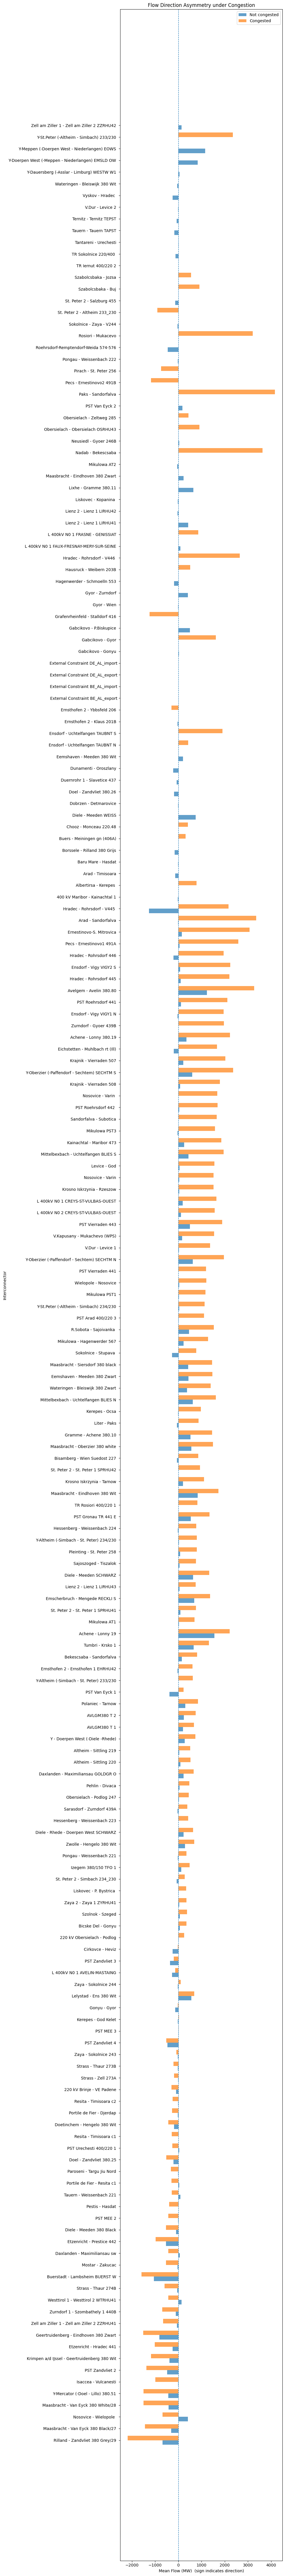

In [104]:
# Plot mean flow (MW) by Line for congested vs not congested, plus differences

def flow_direction_asymmetry(df: pd.DataFrame) -> pd.DataFrame:
    """Compute mean flow (MW) by Line for congested vs not congested, plus differences."""
    x = df.copy()
    x["congested"] = x["congested"].astype(bool)
    x["Flow_MW"] = pd.to_numeric(x["Flow_MW"], errors="coerce")
    x = x.dropna(subset=["Line", "Flow_MW", "congested"])

    summary = (
        x.groupby(["Line", "congested"])["Flow_MW"]
         .mean()
         .unstack("congested")
         .rename(columns={False: "mean_flow_not_congested", True: "mean_flow_congested"})
    )

    # Ensure both columns exist even if one regime is missing for a line
    for col in ["mean_flow_not_congested", "mean_flow_congested"]:
        if col not in summary.columns:
            summary[col] = np.nan

    summary["delta_flow_cong_minus_free"] = (
        summary["mean_flow_congested"] - summary["mean_flow_not_congested"]
    )

    # Optional: absolute magnitude change
    summary["delta_abs_flow_cong_minus_free"] = (
        summary["mean_flow_congested"].abs() - summary["mean_flow_not_congested"].abs()
    )

    return summary.reset_index()


def plot_flow_direction_asymmetry(summary: pd.DataFrame, sort_by: str = "delta_flow_cong_minus_free"):
    """Horizontal bar plot with two bars per line, plus a zero reference."""
    s = summary.copy()
    if sort_by in s.columns:
        s = s.sort_values(sort_by)

    lines = s["Line"].to_numpy()
    y = np.arange(len(lines))
    h = 0.38

    fig, ax = plt.subplots(figsize=(10, max(4, 0.45 * len(lines))))

    ax.barh(y - h/2, s["mean_flow_not_congested"], height=h, alpha=0.7, label="Not congested")
    ax.barh(y + h/2, s["mean_flow_congested"], height=h, alpha=0.7, label="Congested")

    ax.axvline(0, linestyle="--", linewidth=1)
    ax.set_yticks(y)
    ax.set_yticklabels(lines)

    ax.set_title("Flow Direction Asymmetry under Congestion")
    ax.set_xlabel("Mean Flow (MW)  (sign indicates direction)")
    ax.set_ylabel("Interconnector")
    ax.legend()

    plt.tight_layout()
    plt.show()


# --- Run ---
summary = flow_direction_asymmetry(df_flow)
plot_flow_direction_asymmetry(summary)